In [1]:
!ls
# Numerical Imporst 
import pandas as pd
import numpy as np
import scipy 

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

# Python 
import os

# sklearn 
from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

# scipy
from scipy.cluster import hierarchy as hc # for dendograms 



final_after_na.ipynb  Full-Copy4.ipynb	Full.ipynb	    sum_tab_1.csv
final.ipynb	      Full-Copy5.ipynb	NA.ipynb	    test_cli.tsv
Full-Copy10.ipynb     Full-Copy6.ipynb	output.csv	    test_pro.tsv
Full-Copy1.ipynb      Full-Copy7.ipynb	README.txt	    train_cli.tsv
Full-Copy2.ipynb      Full-Copy8.ipynb	start.ipynb	    train_pro.tsv
Full-Copy3.ipynb      Full-Copy9.ipynb	subchallenge_1.csv


In [2]:
df_train_pro = pd.read_table(f'{os.getcwd()}/train_pro.tsv', 
                           delim_whitespace=True,
                           low_memory=False,).T
df_test_pro = pd.read_table(f'{os.getcwd()}/test_pro.tsv', 
                           delim_whitespace=True,
                           low_memory=False,).T
df_train_cli = pd.read_csv(f'{os.getcwd()}/train_cli.tsv', 
                           delim_whitespace=True,
                           low_memory=False,)
df_test_cli = pd.read_csv(f'{os.getcwd()}/test_cli.tsv', 
                           delim_whitespace=True,
                           low_memory=False,)
df_train_mislabel = pd.read_csv(f'{os.getcwd()}/sum_tab_1.csv', 
                           low_memory=False,)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
# df_train_pro
# df_test_pro
# df_train_cli
# df_test_cli
# df_train_mislabel

In [3]:
# Come back to the way you handle this NA, sophisticated way will imporve by at least 5% 
train_pro = df_train_pro.copy(deep=True)
train_pro = train_pro.fillna(train_pro.mean())
train_pro.index.name = 'sample'


test_pro = df_test_pro.copy(deep=True)
test_pro = test_pro.fillna(test_pro.mean())
test_pro.index.name = 'sample'

# df_train_pro
# train_pro
# df_test_pro
# test_pro

In [4]:
train_cli = df_train_cli.copy(deep=True)
train_cli = train_cli.set_index('sample')
train_cli = train_cli.replace({'gender': {'Male':0, 'Female':1},
                              'msi': {'MSI-Low/MSS':0, 'MSI-High':1}})

test_cli = df_test_cli.copy(deep=True)
test_cli = test_cli.set_index('sample')
test_cli = test_cli.replace({'gender': {'Male':0, 'Female':1},
                              'msi': {'MSI-Low/MSS':0, 'MSI-High':1}})
# df_train_cli
# train_cli
# df_test_cli
# test_cli

In [5]:
train_mislabel = df_train_mislabel.copy(deep=True)
train_mislabel = train_mislabel.set_index('sample')

# df_train_mislabel
# train_mislabel

In [6]:
train_pro.reset_index(drop=True, inplace=True)
train_cli.reset_index(drop=True, inplace=True)
train_mislabel.reset_index(drop=True, inplace=True)
# train_pro
# train_cli
# train_mislabel
train_combined = pd.concat([train_mislabel, train_cli, train_pro], axis=1)
# train_combined

In [7]:
train_final2 = train_combined [['gender', 'AGRN', 'ARFIP1',
                                'msi', 'CASK', 'ANP32E',]]


columns = train_final2.columns

# train_final2
# train_combined

In [8]:
X_final2_train, X_final2_valid, y_final2_train, y_final2_valid = train_test_split(train_final2.values.astype(int),
                                                                                  train_combined.mismatch.values, 
                                                                                  test_size=0.3)

 1) ANP32E                         0.277476
 2) CASK                           0.192117
 3) ARFIP1                         0.169807
 4) msi                            0.152694
 5) AGRN                           0.126772
 6) gender                         0.081134


<BarContainer object of 6 artists>

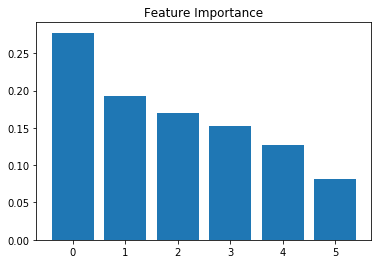

In [9]:
final2_forest = RandomForestClassifier(n_estimators=500, 
                                      min_samples_leaf=3,
                                      max_features=None,
                                      n_jobs=-1,
                                      oob_score=True)

final2_forest.fit(X_final2_train, y_final2_train)

final2_importances = final2_forest.feature_importances_
final2_indices = np.argsort(final2_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(len(columns)):
    print("%2d) %-*s %f" % (f + 1, 30, columns[final2_indices[f]], final2_importances[final2_indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_final2_train.shape[1]), final2_importances[final2_indices], align='center')

In [27]:
final2_select = SelectFromModel(final2_forest, threshold=0.01)

final2_select.fit(X_final2_train, y_final2_train)

X_final2_important_train = final2_select.transform(X_final2_train)
X_final2_important_train_df = pd.DataFrame(X_final2_important_train)
X_final2_important_valid = final2_select.transform(X_final2_valid)
final2_forest.fit(X_final2_important_train, y_final2_train)
y_final2_pred = final2_forest.predict(X_final2_important_valid)
print('Random Forest: \n', classification_report(y_true=y_final2_valid, y_pred=y_final2_pred))
print('OOB score: ', final2_forest.oob_score_)

Random Forest: 
              precision    recall  f1-score   support

          0       0.71      1.00      0.83        17
          1       0.00      0.00      0.00         7

avg / total       0.50      0.71      0.59        24

OOB score:  0.9107142857142857


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


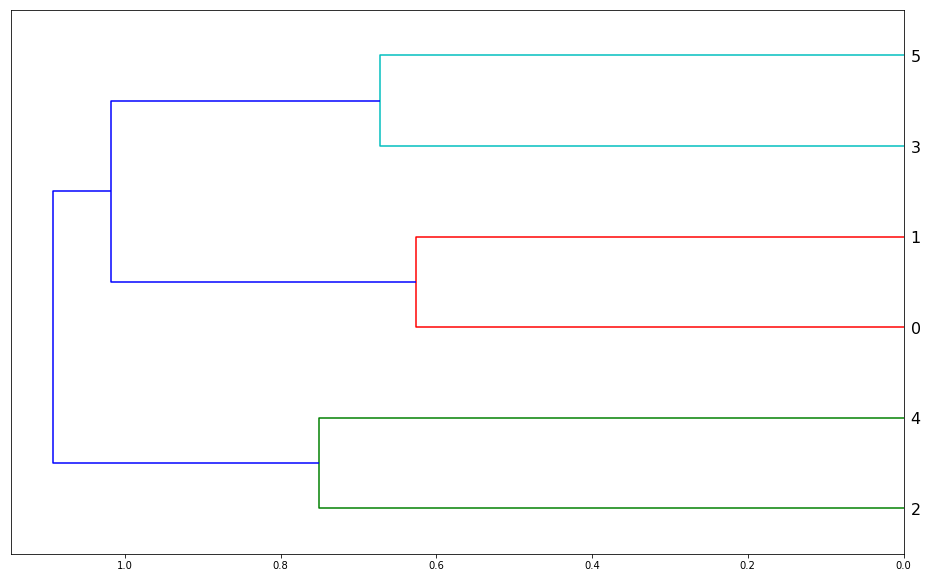

In [28]:
final2_corr = np.round(scipy.stats.spearmanr(X_final2_important_train).correlation, 4)
final2_corr_condensed = hc.distance.squareform(1-final2_corr)
final2_z = hc.linkage(final2_corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
final2_dendrogram = hc.dendrogram(final2_z, labels=X_final2_important_train_df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [10]:
test_pro.reset_index(drop=True, inplace=True)
test_cli.reset_index(drop=True, inplace=True)
test_combined = pd.concat([test_cli, test_pro], axis=1)

test_final = test_combined[['gender', 'AGRN', 'ARFIP1', 'msi', 'CASK', 'ANP32E',]]
X_test = test_final.values.astype(int)


In [11]:
forest = RandomForestClassifier(n_estimators=500, 
                                n_jobs=-1, 
                                oob_score=True)

# sorted(forest.get_params().keys())

gs = GridSearchCV(estimator=forest,
                  param_grid=[{'min_samples_leaf':[1, 3, 5, 10, 25, 100, 250, 500], 
                               'max_features':[None, 0.5, 'sqrt', 'log2']}],
                  cv=5,)

gs = gs.fit(X_final2_train, y_final2_train)
print(gs.best_score_)
print(gs.best_params_)


0.8571428571428571
{'max_features': None, 'min_samples_leaf': 5}


In [38]:
forest.fit(train_final2.values.astype(int), train_combined.mismatch.values)
y_pred = forest.predict(X_test)

y_pred_df = pd.DataFrame(y_pred)

y_pred_df.to_csv('subchallenge_1.csv')

In [37]:
y_pred_df

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
